# Модель бейзлайна на средних
В этом ноубуке мы построим модель бейзлайна с помощью реализованных классов и функций и попробуем выбить лучшую метрику

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Загрузка и обработка данных

In [23]:
# мои файлы
from data_process import load_data, process_outliers, process_missing_values, format_features, split_data
from baseline_model import MeansModel

In [32]:
info =  {
    'offer_id': 'keep',
    'n_photos': 'keep',
    'source': 'keep',
    'house_guid': 'keep',
    'house_lat': 'keep',
    'house_lon': 'keep',
    'floor': 'keep',
    'rooms': 'keep',
    'renovation': 'delete',
    'repair_class_id': 'mean',
    'quality_class_id': 'mean',
    'quality': 'mean',
    'balconies': 0,
    'loggias': 0,
    'area_total': 'keep',
    'living_area': 'change',
    'kitchen_area': 'change',
    'built_year_fillna_own': 'delete',
    'built_year_fillna_sim_low': 'median',
    'entrance_count': 'mode',
    'elevators_count': 'mode',
    'floors_fillna_own': 'mode',
    'wall_material_fillna_own': 'delete',
    'wall_material_fillna_sim_low': 'mode',
    'ceiling_height_fillna_own': 'mode',
    'flat_class_mean': 'mean',
    'is_apartment_mean': 'mean',
    'region': 'keep',
    'amenities': 'keep',
    'infrastructure': 'keep',
    'commission': 'delete',
    'deposit': 'mean',
    'haggle': 'True',
    'communal_payments': 'delete',
    'price': 'keep',
}

In [25]:
# загрузим данные
data = load_data() 

# убираем выбросы
data = process_outliers(data)

# заполняем пропущенные значения
data = process_missing_values(data, info)

# добавим новые признаки
data = format_features(data)

/Users/aksveronika/Desktop/Курсовая/data_process.py:18: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv('/Users/aksveronika/Desktop/Курсовая/analogs_2023-05-31_2023-06-30.csv')


In [26]:
columns_with_missing_values = data.columns[data.isnull().any()]

# У каких признаков есть пропуски и сколько их
print(data[columns_with_missing_values].isnull().sum())

a_repair_class_id         895924
b_repair_class_id         646017
a_quality_class_id        895924
b_quality_class_id        646017
a_quality                 895924
b_quality                 646017
a_living_area            2102874
b_living_area            2161587
a_kitchen_area           1110243
b_kitchen_area           1295136
repair_class_id_diff     1423550
quality_class_id_diff    1423550
quality_diff             1423550
dtype: int64


In [27]:
train, val, test = split_data(data)

Размер train выборки: 7769926
Размер val выборки: 452150
Размер test выборки: 367390
Уникальных объектов в train: 39560
Уникальных объектов в val: 4945
Уникальных объектов в test: 4946


## Модель

Построим базовую модель без улучшений и посмотрим на качество

In [28]:
from baseline_model import MeansModel

baseline_model = MeansModel()
baseline_model.predict(train)

,a_offer_id,a_price,target_price
0,16309055,380000.0,299090.616558
1,109116854,225000.0,434727.925770
2,109116931,230000.0,248277.635063
3,109116936,843249.0,281863.301151
4,109116967,450000.0,295621.260070
...,...,...,...
39555,1854164918,50000.0,316190.289604
39556,1854174251,49000.0,44765.217391
39557,1854174255,60000.0,66945.945946
39558,1854216725,19000.0,41576.923077


In [29]:
baseline_model.calculate_metric(baseline_model.predict(train)), baseline_model.calculate_metric(baseline_model.predict(test))

(54.406670375977086, 56.17990445814923)

### В разрезе максимально допустимого количества аналогов

Будем ограничивать число аналогов и смотреть на изменение метрики

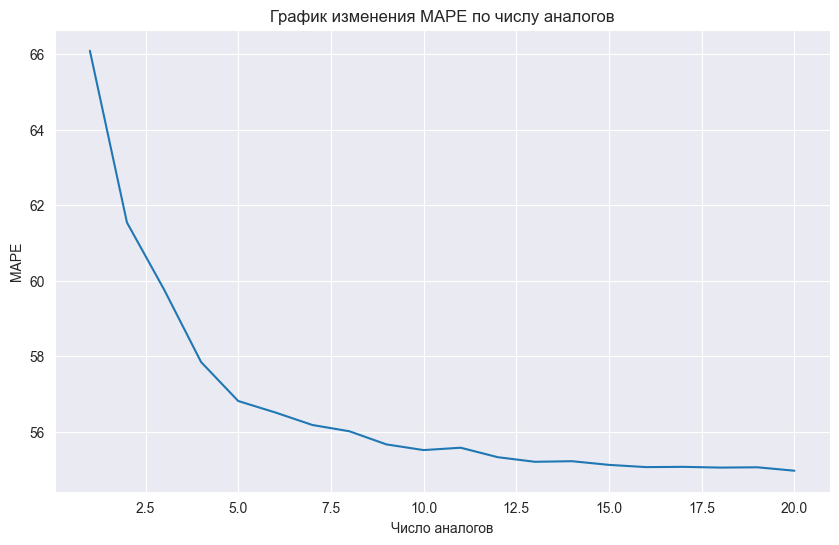

[66.09284034148398,
 61.53967486424791,
 59.76595014519154,
 57.84061585205651,
 56.80973983721327,
 56.50605203780397,
 56.174134290454845,
 56.0072633240295,
 55.65857628126389,
 55.50908084954581,
 55.57131959957334,
 55.32051057748069,
 55.19845217152026,
 55.21444799794707,
 55.11686253584488,
 55.057878791345225,
 55.06466088610302,
 55.045201725219606,
 55.053021314525,
 54.96196122796576]

In [9]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_analogs_num=range(1, 21))
baseline_model.fit(train, title='График изменения MAPE по числу аналогов')

Если мы рандомно ограничиваем число аналогов, то качество будет расти с увеличением числа аналогов.

## Cортировка по отклонению по площади:

После локации один из самых значимых признаков - это общая площадь квартиры. Поэтому попробуем ограничивать число аналогов после сортировки отклонения по площади.

### В разрезе максимально допустимого количества аналогов

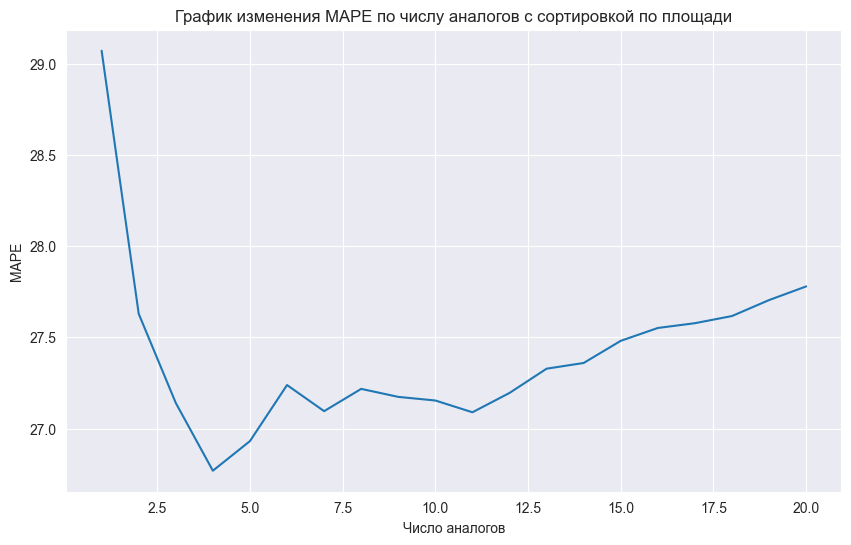

In [10]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_analogs_num=range(1, 21), sort_by=['area_total_diff'])
mape_grid = baseline_model.fit(train, title='График изменения MAPE по числу аналогов с сортировкой по площади')

In [11]:
min_value = min(mape_grid)
min_index = mape_grid.index(min_value)
print(f'best MAPE: {min_value}')
print(f'best analogs_num: {range(1, 21)[min_index]}')

best MAPE: 26.769302821761837
best analogs_num: 4


### Покрытие в разрезе максимально допустимого отклонения по площади

Посмотрим как много данных у нас остается, если мы ограничиваем максимальное отклонение.

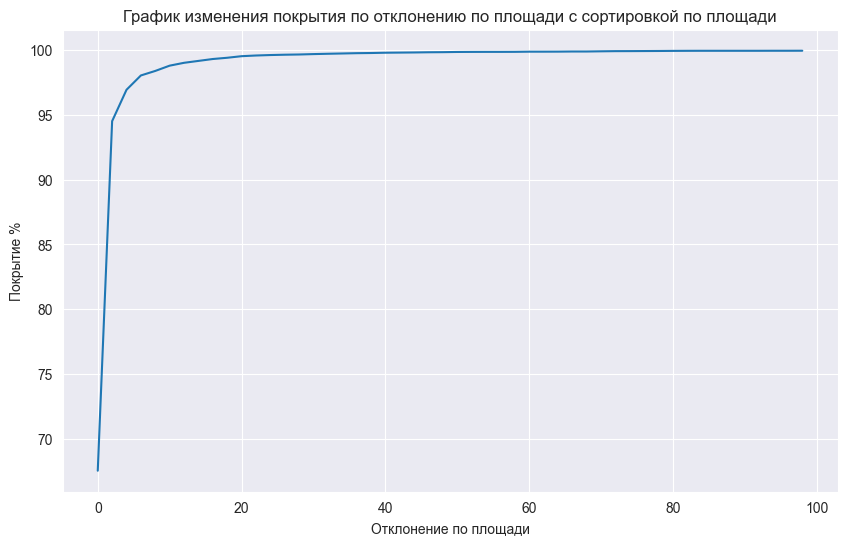

In [12]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_max_area_diff=range(0, 100, 2), sort_by=['area_total_diff'], coverage=True)
mape_grid, coverage_grid = baseline_model.fit(train, title='График изменения покрытия по отклонению по площади с сортировкой по площади')


In [13]:
print(f'Максимальное отклонение по площади, при котором мы покрываем >= 99% объектов: {6}')

Максимальное отклонение по площади, при котором мы покрываем >= 99% объектов: 6


### В разрезе максимально допустимого отклонения по площади

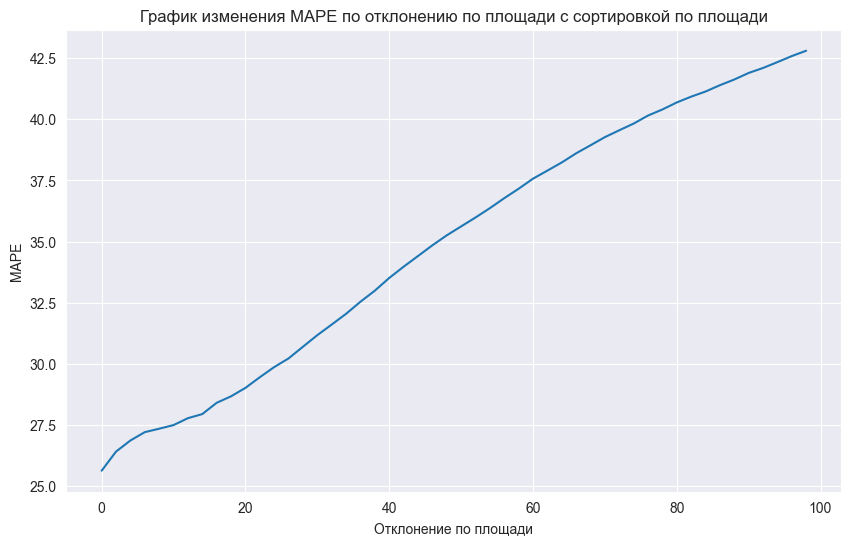

In [14]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_max_area_diff=range(0, 100, 2), sort_by=['area_total_diff'])
mape_grid, coverage_grid = baseline_model.fit(train, title='График изменения MAPE по отклонению по площади с сортировкой по площади')


In [15]:
min_value = min(mape_grid)
min_index = mape_grid.index(min_value)
print(f'best MAPE: {min_value}')
print(f'best max_area_total_diff: {range(0, 100, 2)[min_index]}')

best MAPE: 25.624995086680556
best max_area_total_diff: 0


### В разрезе максимально допустимого количества аналогов с сортировкой по ремонту, площади

Еще один значимый признак это ремонт. Поробуем сортировать аналоги по разнице в ремонте.

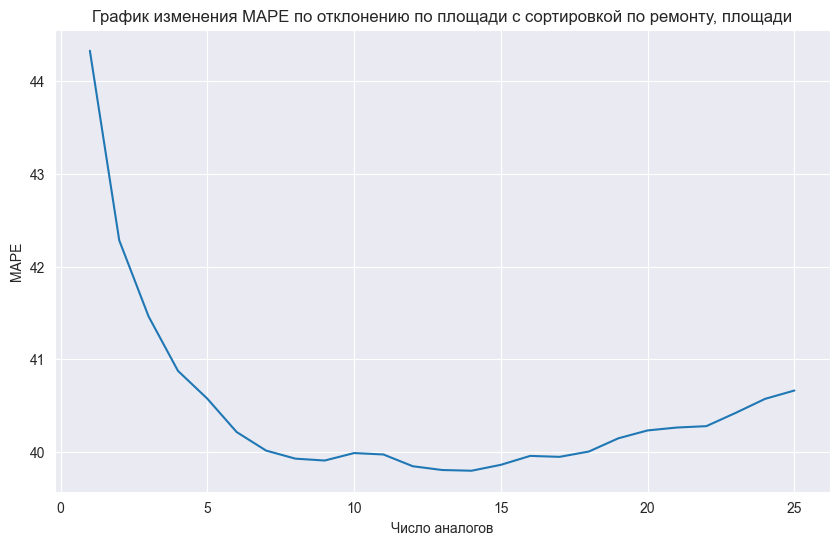

In [16]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_analogs_num=range(1, 26), sort_by=['quality_diff', 'area_total_diff'])
mape_grid = baseline_model.fit(train, title='График изменения MAPE по отклонению по площади с сортировкой по ремонту, площади')

In [17]:
min_value = min(mape_grid)
min_index = mape_grid.index(min_value)
print(f'best MAPE: {min_value}')
print(f'best analogs_num: {range(1, 26)[min_index]}')

best MAPE: 39.79933060031862
best analogs_num: 14


### В разрезе максимально допустимого количества аналогов с сортировкой по ремонту, площади

Объединим оба признака.

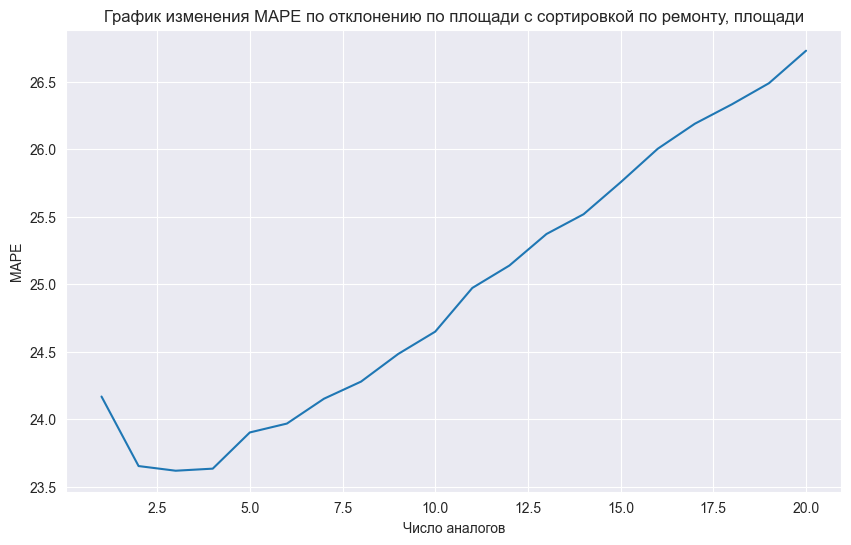

In [35]:
from baseline_model import MeansModel

# train['quality_diff_round'] = train['quality_diff'].round()
baseline_model = MeansModel(find_analogs_num=range(1, 21), sort_by=['quality_class_id_diff', 'area_total_diff'])
mape_grid = baseline_model.fit(train, title='График изменения MAPE по отклонению по площади с сортировкой по ремонту, площади')

In [36]:
min_value = min(mape_grid)
min_index = mape_grid.index(min_value)
print(f'best MAPE: {min_value}')
print(f'best analogs_num: {range(1, 21)[min_index]}')

best MAPE: 23.61805927414965
best analogs_num: 3
